# Names (Enter your names below)
**Your Name and JHED:** Michelle Wang mwang139

**Partner's Name and JHED (If applicable):**  Dru Zheng dzheng12

# Lab 2: Classification of Cardiomyocites Based on Their Action Potentials

By **Benjamín Béjar Haro** and edited by **Kwame Kutten**

In this lab we will be looking at the problem of classifying cardiac cells by looking at their _Action Potentials_ (APs). For the purpose of this task we will be using synthetically
generated APs following the models in [(Nygren et. al, 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et. al, 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).

### Objectives
By the end of this session you should be able to use nearest-neighbor and simple neural network classifiers for two-class classification problems.


In [46]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random as rnd
# set random number generator seed
rnd.seed(10)

try:
    import torch
    import sklearn
except:
    # Install packages if not available
    !conda install -y -c pytorch pytorch
    !conda install -y -c anaconda scikit-learn 
    import torch

# inline plots
%matplotlib inline

In [47]:
# ============================================================================
# Edit path variable below if necessary
# ============================================================================
try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount('gdrive/')
    path = "gdrive/My Drive/" # Change path to location of data if necessary
except:
    # Executes if running locally (e.g. Anaconda)
    path = "./"

# get the list of files to process
matfile = '/'.join((path,'Adult_samples.mat'))

# get data as dictionary
adata = scipy.io.loadmat(matfile)

# see the keys of the dictionary 'Vatrial' and 'Vventricular'
# adata['Vatrial'] contains action potentials of cardiac cells of atrial type
# adata['Vventricular'] contains action potentials of cardiac cells of ventricular type
adata.keys()

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).


dict_keys(['__header__', '__version__', '__globals__', 'Vatrial', 'Vventricular'])

(347, 1000)
(347, 1000)


Text(0.5, 0, 'sample')

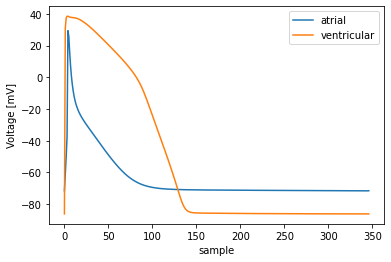

In [48]:
# look at the data dimensions
print(adata['Vatrial'].shape)
print(adata['Vventricular'].shape)

# let's see how the data looks like
plt.plot(adata['Vatrial'][:,0])
plt.plot(adata['Vventricular'][:,0])
plt.legend(('atrial','ventricular'))
plt.ylabel('Voltage [mV]')
plt.xlabel('sample')

### Part 1. Classification Using Hand-crafted Features [50 points total]
In this first part we will be normalizing the data and extracting hand-crafted features that will be used for classification. For each of the two classes there are $1000$ samples generated with a sampling rate of $f_s=500$ Hz. Here we create array **`X`** with **columns** that contains examples of adult atrial and ventricular action potentials generated using the models in [(Nygren et al., 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et al., 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061). We also create **`Y`** containing labels of $+1$ for ventricular type and $-1$ for atrial type.

In [49]:
# Extract atrial data
X_atrial = adata['Vatrial']
[D, N_atrial] = X_atrial.shape # D dimension of features (number of time points )

# Extract ventricular data
X_ventricular = adata['Vventricular']
N_ventricular = X_ventricular.shape[1]

ratioTrain = 0.1
f_s = 500

X = np.concatenate([X_ventricular, X_atrial], axis=1)
Y = np.concatenate([np.ones(N_ventricular), -np.ones(N_atrial)])


 * **Task 1A: Normalize [4 points]:** Normalize the data so that each AP has 0.0 resting potential and maximum amplitude of 1.0  .

Text(0.5, 0, 'sample')

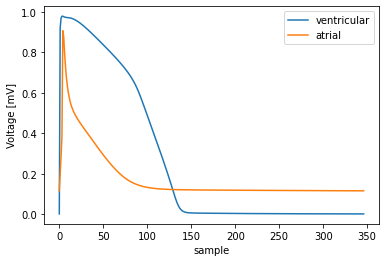

In [59]:
def NormalizeData(X):
    return (X - np.min(X)) / (np.max(X) - np.min(X))
normx = NormalizeData(X)
plt.plot(normx [:,0] )
plt.plot(normx [:,1000] )
plt.legend(('ventricular','atrial'))
plt.ylabel('Voltage [mV]')
plt.xlabel('sample')

 * **Task 1B: Train-Test Split [5 points]:** Split the data between test and training sets by randomly selecting $10\%$ of the points as your training set. Make sure the two classes are well represented in the training set (e.g., use the same number for both). **Hint:** You may find [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) helpful here.

(1000, 347)
(1000, 347)
(347, 100)
(347, 100)


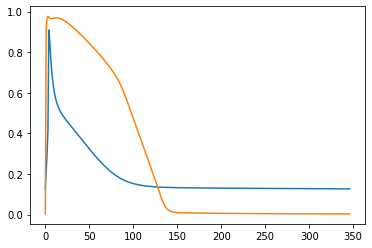

In [126]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
t = np.transpose(normx)
newarr = np.array_split(t, 2)
norm_ventricular = newarr[0]
norm_atrial = newarr[1]


print(norm_ventricular.shape)
print(norm_atrial.shape)

# do i need to use random_state=instance ?
X_train, X_test, Y_train, Y_test = train_test_split(norm_atrial, norm_ventricular, test_size =0.90)


X_train = np.transpose(X_train)
Y_train = np.transpose(Y_train)
X_test = np.transpose(X_test)
Y_test = np.transpose(Y_test)

print(X_train.shape)
print(Y_train.shape)
plt.plot(X_train [:,0])
plt.plot(Y_train[:,0])

 * **Task 1C: Atrial and Ventricular AP Plots [3 points each, 6 Points Total]:**
 Make two plots displaying your normalized training data for each of the classes. Horizontal axis should be time in seconds

(100, 347)
(100, 347)


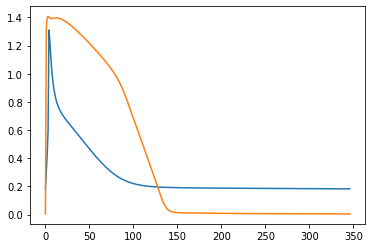

In [127]:
from numpy.lib import type_check
time = (347/500)

X_train = np.transpose(X_train)
Y_train = np.transpose(Y_train)

ttime = np.full((100,347),time)
x = np.divide(X_train, ttime)
y = np.divide(Y_train, ttime)

"""x = np.transpose(x)
y = np.transpose(y)

x = np.arange(0, time + 0.01,0.01, X_train)
y = np.arange(0, time + 0.01,0.01, Y_train)
tx = np.transpose(X_train)
ty = np.transpose(Y_train)

Xn_train = tx*time
Yn_train = ty*time

x = np.transpose(Xn_train)
y = np.transpose(Yn_train)"""





print(Xn_train.shape)
print(Yn_train.shape)
plt.plot(x [:,0])
plt.plot(y [:,0])



* **Task 1D: APD [10 points]:** The _Action Potential Duration_ (APD) at $\alpha$ is defined as the time it takes to reduce the maximum amplitude of the AP to a proportion $\alpha \in[0,1]$ of that value. Write a function that computes APD at a given $\alpha$. Then use it to calculate the APD at $\alpha=0.5$ for all APs in the train and test datasets.

In [ ]:
# ============================================================================
# compute hand-crafted features such as APA and APDx
# ============================================================================

def apdx(X,alpha=0.5,fs=1.0):
    """
    This function computes the APDx feature defined as the time it takes to
    reduce the action potential to x% of its maximum value.
    Use:
        APD = apdx(X,alpha,fs)
        
    Inputs:
        X : data points (each column is a data point)
        alpha : [0,1] proportion of maximum amplitude
        fs : sampling frequency (to map samples to time)
        
    Output:
        APD feature
    """

    # write your function code here
    # ...


 * **Task 1E: APP [5 points]:** Also compute the _Average of the Action Potential_ (AAP) for both the train and test datasets

 * **Task 1F: APD vs. AAP Scatter Plot [5 points]:** Make a scatter plot (APD\@0.5 vs. AAP) of the training data using these two features. Use different colors and/or markers to represent each class.


* **Task 1G: Nearest-neighbor classifier [15 points]** Implement a $1$NN classifier using the Euclidean distance. A $1$NN classifier works as follows: Given your training dataset $\mathcal{D} = \big\{(\boldsymbol x_i,y_i)\big\}_{i=1}^{N}$,where $N$ is the number of training samples, $\boldsymbol x_i\in\mathbb{R}^D$ is a feature vector and $y_i\in\{-1,1\}$ its associated label, and a novel sample $\boldsymbol x$, the $1$NN classifier assigns to $\boldsymbol x$ the same label as its closest point in the training set. That is, the estimated label $\widehat y$ of $\boldsymbol x$ is such that:

$$\widehat y(\boldsymbol x) = y_{k^*},\quad k^* = \underset{i\in\{1,\ldots,N\}}{\arg\min}\, \lVert \boldsymbol x_i - \boldsymbol x \rVert_2. $$ 

Compute and display the classification accuracy over the testing dataset using the handcrafted training features APD and AAP.

In [ ]:
# ============================================================================
# Nearest-neighbor classifier
# ============================================================================

def nn_classify(Xtest,Xtrain,Ytrain):
    """
    This function implements a nearest neighbor classifier.
    Use:
        yhat = nn_classify(Xtest,Xtrain,Ytrain)
        
    Inputs:
        Xtest  : test data points (each column is a data point)
        Xtrain : training data points
        Ytrain : associated labels to the training data points
        
    Output:
        Yhat : estimated labels for the test data.

    """
    
    # implement your nearest-neighbor classifier below
    # ...


### Part 2. Classification Using Neural Network [40 points total]

Implement a two-layer neural network classifier of the form:

   $$\widehat y = \operatorname{sign}\big(f_{\theta}(\phi(\boldsymbol x))\big),\quad f_{\theta}(\phi(\boldsymbol x)) = \boldsymbol w^T\phi(\boldsymbol x) + b,\quad \theta = \left[\begin{array}{c}\boldsymbol w\\b\end{array}\right],$$
  
 where $x \in \mathbb{R}^D$, $f_\theta: \mathbb{R}^p \to \mathbb{R}$ is a _linear prediction function_ (i.e., classification layer) with $p$ parameters. Furthermore we define $\theta = [\boldsymbol w^T, b]^T$ with $w \in \mathbb{R}^p$ and $b \in \mathbb{R}$. The feature extraction part of the network consists of a linear layer followed by a ReLu (rectified linear unit) non-linearity:
 
 $$ \phi(x) = \operatorname{ReLu}\big(\boldsymbol W \boldsymbol x + \boldsymbol B\big),\quad\operatorname{ReLu}(x)=\begin{cases}x &x>0\\0&\textrm{else}\end{cases}.$$
 
 Where $\phi: \mathbb{R}^D \to \mathbb{R}^p$, $\boldsymbol W \in \mathbb{R}^{p \times D}$, $B \in \mathbb{R}^{p}$. In order to find the network's parameters $\Theta=\{\boldsymbol W, \boldsymbol B, \boldsymbol w, b\}$ minimize the following _regularized empirical risk_ using PyTorch:

   $$\min_{\Theta}\, \underbrace{\frac{1}{N} \sum_{i=1}^N L\big(f_\theta(\phi(\boldsymbol x_i)),y_i\big) + \lambda\big(\frac{1}{|w|}\lVert \boldsymbol w\rVert^2 + \frac{1}{|W|}\lVert\boldsymbol W\rVert^2\big)}_{C(\Theta)}$$
    
 where the loss function $L(f, y) = \lVert y-f\rVert_2^2)$ is the quadratic (square) loss, and $|w|,|W|$, are the number of elements in $\boldsymbol w$ and $\boldsymbol W$, respectively. 

 * **Task 2A: Define neural nework [15 points]:** Define a network model in PyTorch according to the definition above. For that purpose you can use `torch.nn.Sequential`. Use $p \geq 2$ for best results.  Follow this [example](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-nn) to learn how to use it.

In [ ]:
p = 2
torch.manual_seed(0) # fix random number generator

# ============================================================================
# Write your solution below based on outline
# ============================================================================

# Define Xtrain as a Ntrain x D tensor and Ytrain should be a Ntrain x 1

# Define a linear function with D inputs and p outputs and include a bias term

# Define a Rectified Linear Unit 

# Define another linear funcion with p inputs and 1 output also include a bias term

# Define model as a neural network combining these 3 functions


 * **Task 2B: Gradient Descent [15 points]:** Run a gradient descent algorithm to minimize the cost function using $\lambda =1$. Carefully adjust the learning rate and number of iterations until you see the method converges (i.e., the cost value function gets to a "plateau").  Print the cost every 500 iterations.

In [ ]:
learningRate = 5e-3
numIterations = 10000
lambdaValue = 1

# ============================================================================
# Write your solution below based on outline
# ============================================================================
for iteration in range(numIterations):
    
    # Use model to predict Y
    
    # Evaluate the cost function 
    
    # Display cost value every 500 iterations
    
    # Backpropagation: Update the gradients of the cost function using it's backward() method
    
    with torch.no_grad():
        # Updating parameters based on gradients
        
        model.zero_grad()
        

 * **Task 2C: Cost Plot [5 points]:** Then plot the cost over the iterations and display the classification accuracy over the testing dataset.

 * **Task 2D: Test Accuracy [5 points]:** Display the classification accuracy over the testing dataset.